  # Test of hierarchical classification (model 2)
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier



  ### Definition of names for plots and files

In [2]:
morethan5 = False

extragalactic = False
galactic = False

nfeatures=60

date = '20200110'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v5.1/dfcrossmatches_prioritized_v5.1.csv'
#detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20200109_with_WISE.csv'
#features_file = '../ZTF_data/features_20191017_filtered.pkl'
#non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

class_output = '../ZTF_classifications/classes_TS_v5.1_new_features_with_WISE_'+date+'.csv'
#where the RF models are saved
if morethan5:
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_morethan5gr_'+date

else: 
    model_first_layer = 'stat_prob_hierRF_model_2/rf_model_2_hierarchical_layer_'+date
    model_periodic_layer = 'stat_prob_hierRF_model_2/rf_model_2_periodic_layer_'+date
    model_transient_layer = 'stat_prob_hierRF_model_2/rf_model_2_transient_layer_'+date
    model_stochastic_layer = 'stat_prob_hierRF_model_2/rf_model_2_stochastic_layer_'+date

#confusion matrixes
if morethan5:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances
if morethan5:
    feature_importance_name_first_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_prob_hierRF_model_2/feature_importance_rf_model_2_stochastic_layer_morethan5gr_'+date
    
else: 
    feature_importance_name_first_layer = '../../paper_late_classifier/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
    feature_importance_name_periodic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
    feature_importance_name_transient_layer = '../../paper_late_classifier/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
    feature_importance_name_stochastic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

### reading the training set files 

In [3]:
#df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_csv(features_file,index_col='oid')
df_labels = pd.read_csv(labels_file,index_col='oid')


#df_wise = pd.read_csv(features_wise,index_col='oid')

#'''
df_feat['W2-W3']=df_feat['W2']-df_feat['W3']
df_feat.loc[(df_feat['W3']==np.nan) |(df_feat['W2']==np.nan) |(df_feat['W2']==-999)|(df_feat['W3']==-999), 'W2-W3']=np.nan

df_feat['r-W3']=df_feat['Mean_2']-df_feat['W3']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W3']==-999) , 'r-W3']=np.nan
df_feat.loc[(df_feat['r-W3']>500) | (df_feat['r-W3']<-500) ,'r-W3']=np.nan 

df_feat['r-W2']=df_feat['Mean_2']-df_feat['W2']
df_feat.loc[(df_feat['Mean_2']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_2']==-999)|(df_feat['W2']==-999), 'r-W2']=np.nan
df_feat.loc[(df_feat['r-W2']>500) | (df_feat['r-W3']<-500),'r-W2']=np.nan 

df_feat['g-W3']=df_feat['Mean_1']-df_feat['W3']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W3']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W3']==-999) , 'g-W3']=np.nan
df_feat.loc[(df_feat['g-W3']>500) | (df_feat['g-W3']<-500) ,'g-W3']=np.nan

df_feat['g-W2']=df_feat['Mean_1']-df_feat['W2']
df_feat.loc[(df_feat['Mean_1']==np.nan) |(df_feat['W2']==np.nan) | (df_feat['Mean_1']==-999)|(df_feat['W2']==-999), 'g-W2']=np.nan
df_feat.loc[(df_feat['g-W2']>500) | (df_feat['g-W3']<-500),'g-W2']=np.nan
#'''

df_feat.to_csv('../ZTF_data/features_20200109_with_WISE_4_Hackathon.csv')

#df_detections = pd.read_pickle(detections_file)
'''
df_paps = pd.read_pickle(features_paps)
df_paps = df_paps.set_index('oid')
df_paps.paps_ratio_1=df_paps.paps_ratio_1.astype(float)
df_paps.paps_ratio_2=df_paps.paps_ratio_2.astype(float)
df_paps.paps_high_2=df_paps.paps_high_2.astype(float)
df_paps.paps_high_1=df_paps.paps_high_1.astype(float)
df_paps.paps_low_2=df_paps.paps_low_2.astype(float)
df_paps.paps_low_1=df_paps.paps_low_1.astype(float)

print(df_paps.dtypes)

df_paps = df_paps.replace([np.inf, -np.inf], np.nan)
df_paps.replace([-99], -999,inplace=True)
df_paps.fillna(-999,inplace=True)
print(np.max(df_paps['paps_ratio_2']))

'''

#deleting columns in df_nd with name ending in "_3"
#for col in list(df_nd):
#    if col[-2:] == "_3":
#        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
#df_det = df_detections.groupby(['oid'])
#df_sgscore = df_det['sgscore1'].median()
#df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_labels.head())

170976
             classALeRCE          ra        dec               period  \
oid                                                                    
ZTF19aavdfaf     CV/Nova  323.746659  40.671826         NON PERIODIC   
ZTF19aaniokz     CV/Nova  306.822433  43.689485               0.0777   
ZTF18accatjz     CV/Nova  331.153495  53.506598                  NaN   
ZTF19aarfrrf     CV/Nova  271.876088  45.858938  0.19362100000000002   
ZTF19aarfrre     CV/Nova  271.876073  45.859003  0.19362100000000002   

                      source id_source class_source  separation_arcsec  
oid                                                                     
ZTF19aavdfaf  CVsJavierAbril  V630 Cyg           CV           0.556391  
ZTF19aaniokz  CVsJavierAbril  V503 Cyg           CV           1.159315  
ZTF18accatjz  CVsJavierAbril    IV Cep           CV           0.742104  
ZTF19aarfrrf  CVsJavierAbril    DQ Her           CV           0.157008  
ZTF19aarfrre  CVsJavierAbril    DQ Her           C

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'EB'
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'EB'
#df_labels.loc[(df_labels['class_original'] == 'AGN-I'), 'class_original'] = 'QSO-I'
#df_labels.loc[(df_labels['class_source'] == 'A') | (df_labels['class_source'] == 'AGN_galaxy_dominated'), 'class_original'] = 'AGN-I'





#defining the classes included in the RF model
#label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO', 'SNIa', 'SNIbc', 'SNII',
#               'SLSN', 'EA', 'EB/EW', 'DSCT', 'RRL', 'Ceph', 'LPV','RSCVn','Periodic-Other']

label_order = ['QSO','AGN', 'Blazar', 'CV/Nova', 'YSO','LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EB', 'DSCT', 'RRL', 'Ceph','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

#labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EA') | (labels['class_hierachical'] == 'EB/EW')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'
labels.loc[(labels['class_hierachical'] == 'RSCVn') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'EB')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'YSO') | (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'CV/Nova')  |   (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(169358,)


,class_original,class_hierachical
oid,,
ZTF19aavdfaf,CV/Nova,Stochastic
ZTF19aaniokz,CV/Nova,Stochastic
ZTF18accatjz,CV/Nova,Stochastic
ZTF19aarfrrf,CV/Nova,Stochastic
ZTF19aarfrre,CV/Nova,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'aps_non_zero_1',
'aps_non_zero_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z',  
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',   
]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''


#print(df_paps.columns)
#paps_drop = ['paps_non_zero_1','paps_PN_flag_1','paps_non_zero_2','paps_PN_flag_2']
#paps_drop = ['paps_non_zero_1','paps_non_zero_2']

wise_drop = ['W1','W2','W3','W4','u','g','r','i','z','u_g','g_r','r_i','i_z']

#rm_nd_cols = rm_nd_cols + wise_drop


#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
#df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))

df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')#.join(df_wise.drop(wise_drop, axis=1),how='left')
print(df['g-r_max'].values.size)
#df = df.join(df_wise.drop(wise_drop, axis=1),how='left')
#print(df['g-r_max'].values.size)
df = df.replace([np.inf, -np.inf], np.nan)
print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

#print(np.max(df['paps_ratio_2'].values))
#print(len(labels['class_original'].values))
#labels = labels.loc[df.index.values]
print(len(labels['class_original'].values))



print(df['g-r_max'].values.size)
df.head()

115941
115941
115941
115941


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,positive_fraction_1,positive_fraction_2,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF18abcoxgp,1.777660,1.612033,1.0,1.0,6.0,8.0,0.607143,0.626866,0.018519,0.000000,...,0.125000,0.194030,0.886667,0.983125,-999.000,-999.000,-999.000000,-999.000000,-999.000000,-999.000000
ZTF18aaavxnm,1.545494,1.355183,1.0,1.0,1.0,1.0,0.100000,0.163636,0.000000,0.018868,...,0.700000,0.763636,0.808571,1.000000,0.439,1.925,4.700925,2.775925,4.654902,2.729902
ZTF18abmefme,1.741148,1.508885,1.0,1.0,1.0,1.0,0.529412,0.521739,0.000000,0.000000,...,0.431373,0.413043,0.912857,0.996042,0.168,2.829,4.799764,1.970764,4.865939,2.036939
ZTF17aabumpu,1.689769,1.102787,1.0,1.0,1.0,1.0,0.176471,0.315789,0.000000,0.000000,...,0.735294,0.631579,0.846667,0.790198,0.026,0.576,2.432245,1.856245,2.667624,2.091624
ZTF18aazmwvg,2.734478,2.477687,1.0,1.0,2.0,3.0,0.428571,0.442623,0.021277,0.000000,...,0.571429,0.655738,0.807857,0.980625,0.440,3.472,4.365933,0.893933,4.910711,1.438711


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    if morethan5: title='Confusion matrix for more than 5 samples per band'
    if extragalactic: title='Confusion matrix for |gal_b|>20'
    if galactic: title='Confusion matrix for |gal_b|<=20'


    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name, nfeat):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    aux=[feature_names[i] for i in I]
    return(aux[0:nfeat])
    #plt.close()

### Pre-processing training data

In [7]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

X_hierarchical = df#.columns.values.tolist()

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
#X_train_periodic.drop(['Mean_2'], axis=1,inplace=True)
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
#X_train_transient.drop(['Mean_2'], axis=1,inplace=True)
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

#X_train_hierarchical.drop(['Mean_2'], axis=1,inplace=True)

X_test_periodic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_stochastic = X_test_hierarchical#.drop(['Mean_2'], axis=1)
X_test_transient = X_test_hierarchical#.drop(['Mean_2'], axis=1)
#X_test_hierarchical = X_test_hierarchical#.drop(['Mean_2'], axis=1)


print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

51851 40030 871


  ## Balanced random forest
  
  ### First layer: separating Periodic, Stochastic and Transients:

In [8]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9842597783431799
Balanced accuracy: 0.9869167492667777


[[ 9719    77   212]
 [    1   217     0]
 [   69     6 12888]]
Normalized confusion matrix


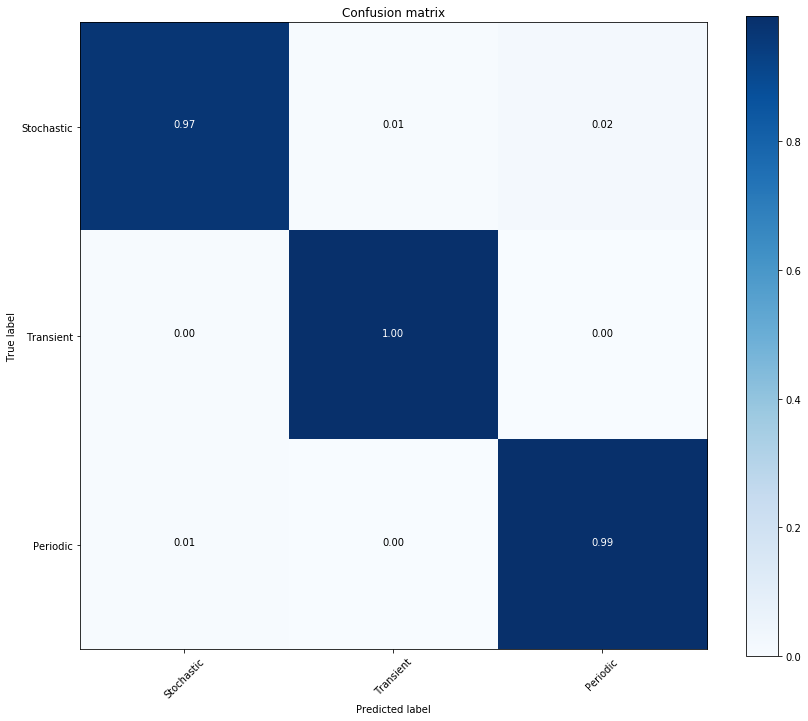

In [9]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

['sgscore1', 'g-W2', 'g-W3', 'positive_fraction_2', 'r-W2', 'LinearTrend_2', 'r-W3', 'W1-W2', 'aps_low_2', 'W2-W3', 'n_non_det_after_fid_2', 'IAR_phi_1', 'GP_DRW_tau_2', 'IAR_phi_2', 'SF_ML_amplitude_2', 'g-r_mean', 'LinearTrend_1', 'Rcs_2', 'g-r_max', 'positive_fraction_1', 'Autocor_length_2', 'aps_high_2', 'GP_DRW_tau_1', 'n_non_det_after_fid_1', 'Amplitude_2', 'GP_DRW_sigma_2', 'delta_mag_fid_2', 'Std_2', 'max_diffmaglim_after_fid_2', 'Rcs_1', 'AndersonDarling_1', 'Eta_e_1', 'Autocor_length_1', 'MedianAbsDev_2', 'Meanvariance_2', 'ExcessVar_2', 'ExcessVar_1', 'SF_ML_amplitude_1', 'median_diffmaglim_after_fid_1', 'GP_DRW_sigma_1', 'max_diffmaglim_after_fid_1', 'Eta_e_2', 'aps_high_1', 'Pvar_2', 'SF_ML_gamma_1', 'median_diffmaglim_after_fid_2', 'Amplitude_1', 'MHAOV_Period_2', 'SF_ML_gamma_2', 'last_mjd_before_fid_2', 'Pvar_1', 'PercentAmplitude_2', 'delta_mag_fid_1', 'PercentAmplitude_1', 'Meanvariance_1', 'aps_PN_flag_2', 'MHAOV_Period_1', 'Q31_2', 'Std_1', 'aps_ratio_2']


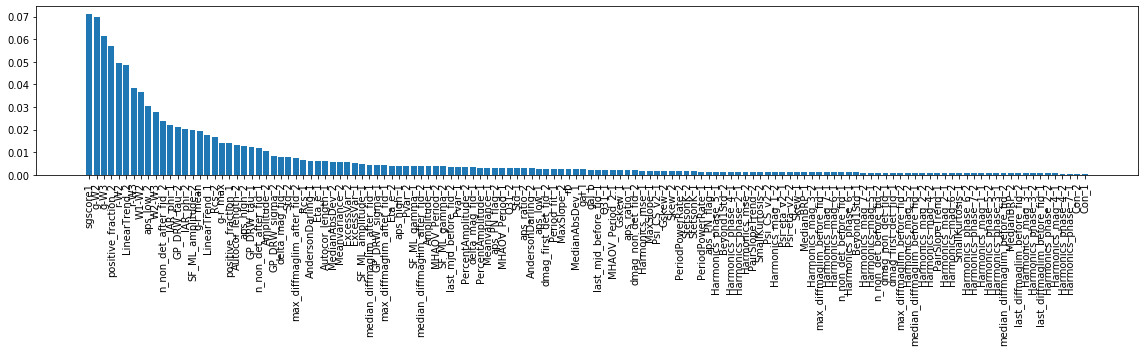

In [10]:
#plotting feature importance
feat_hier = plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer,nfeatures)
print(feat_hier)

In [11]:
#running RF with the first 50 features
X_train_hierarchical = X_train_hierarchical[feat_hier]
X_test_hierarchical = X_test_hierarchical[feat_hier]

rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

classes_order_proba_hierarchical = rf_model_hierarchical.classes_
print(classes_order_proba_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_train_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,
            'features': features_hierarchical,
            'order_classes': classes_order_proba_hierarchical
            }
        pickle.dump(model_dump, pickle_file)

['Periodic' 'Stochastic' 'Transient']
Accuracy: 0.9841304066583294
Balanced accuracy: 0.9868168292028289


[[ 9716    78   214]
 [    1   217     0]
 [   65    10 12888]]
Normalized confusion matrix


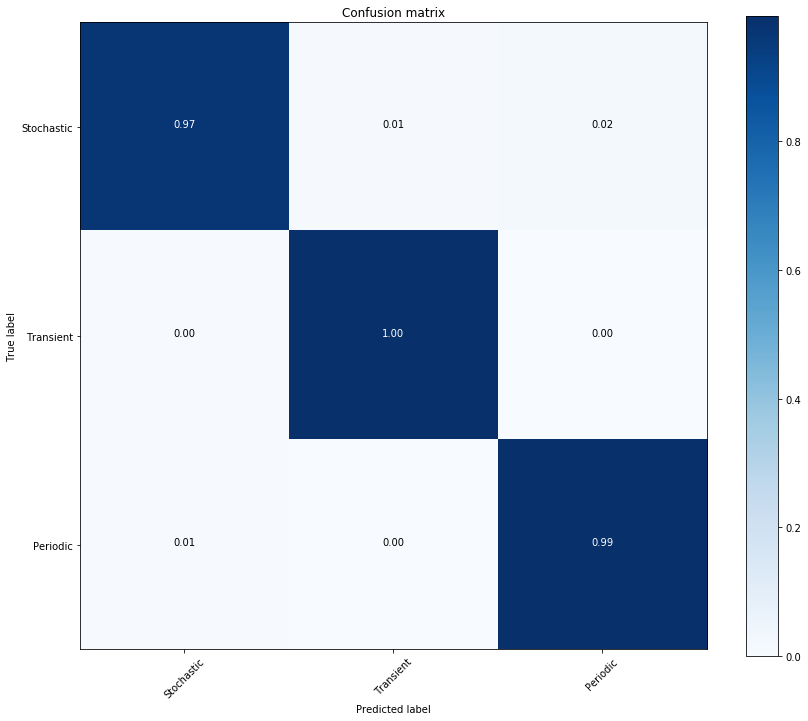

In [12]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

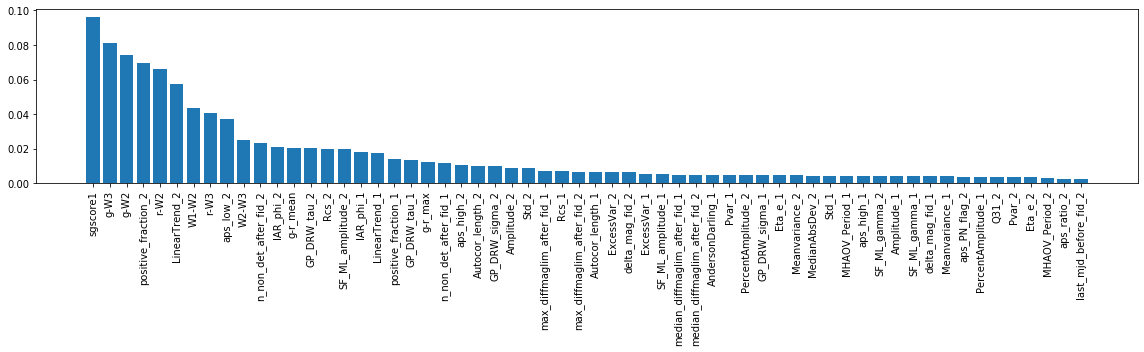

In [13]:
feat_hier2 = plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer,nfeatures)

  ### Periodic layer

In [14]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)

# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']


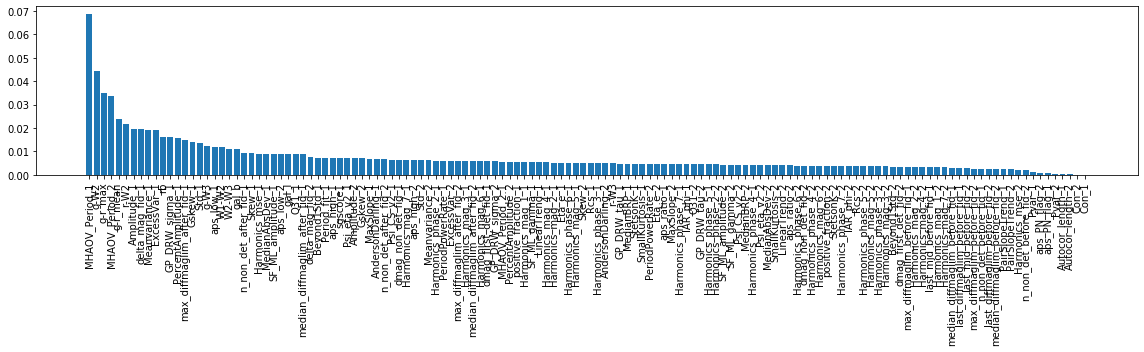

In [15]:
#plotting feature importance
feat_periodic = plot_feature_importances(rf_model_periodic, features_periodic, feature_importance_name_first_layer,nfeatures)

In [16]:
#running RF with the first 20 features
X_train_periodic = X_train_periodic[feat_periodic]
X_test_periodic = X_test_periodic[feat_periodic]

rf_model_periodic.fit(X_train_periodic, y_train_periodic)

# Applying periodic model to the test data
y_true_periodic, y_pred_periodic = y_test_original, rf_model_periodic.predict(X_test_periodic)
y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)

#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            'order_classes': classes_order_proba_periodic
            }
        pickle.dump(model_dump, pickle_file)

['Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']


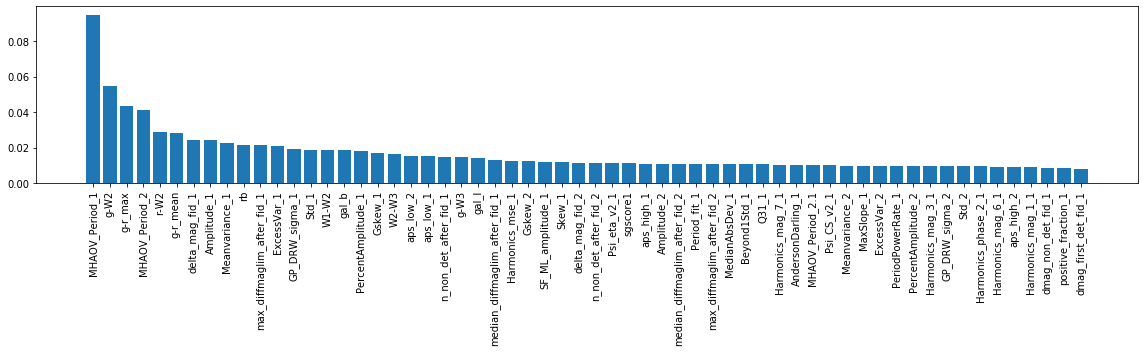

In [17]:
#plotting feature importance
feat_periodic2 = plot_feature_importances(rf_model_periodic, features_periodic, feature_importance_name_first_layer,nfeatures)

  ### Stochastic layer

In [18]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO']


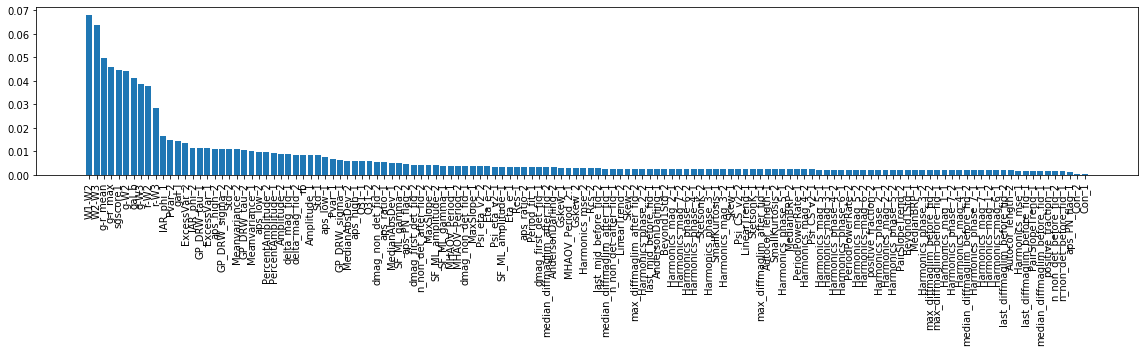

In [19]:
#plotting feature importance
feat_stochastic = plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer,nfeatures)

In [20]:
#running RF with the first 20 features
X_train_stochastic = X_train_stochastic[feat_stochastic]
X_test_stochastic = X_test_stochastic[feat_stochastic]

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)

# Applying stochastic model to the test data
y_true_stochastic, y_pred_stochastic  = y_test_original, rf_model_stochastic.predict(X_test_stochastic)
y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            'order_classes': classes_order_proba_stochastic
            }
        pickle.dump(model_dump, pickle_file)

['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO']


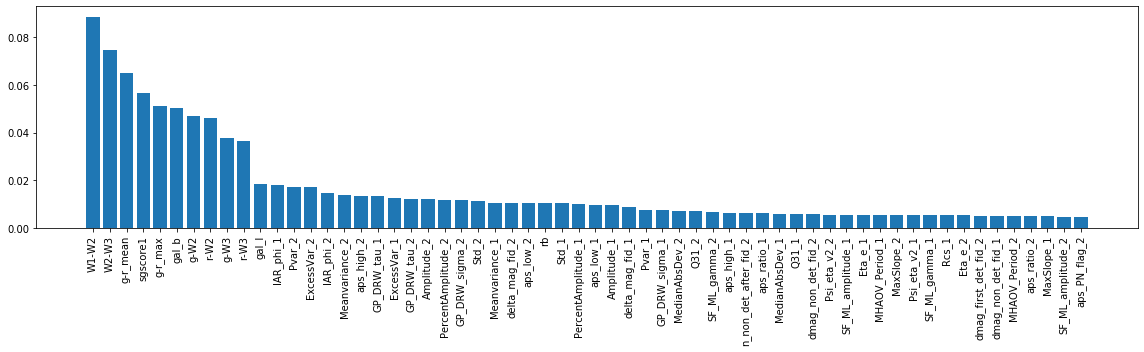

In [21]:
#plotting feature importance
feat_stochastic2 = plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer,nfeatures)

  ### Transient layer

In [22]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


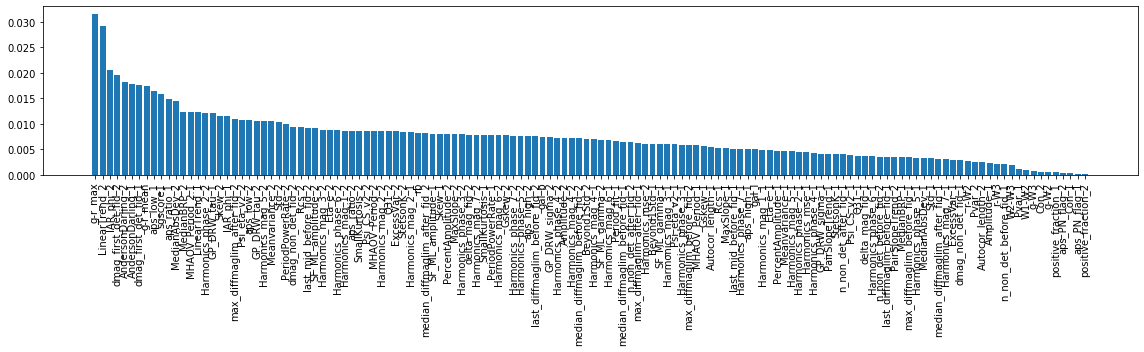

In [23]:
#plotting feature importance
feat_transient = plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer,nfeatures)

In [24]:
#running RF with the first 20 features
X_train_transient = X_train_transient[feat_transient]
X_test_transient = X_test_transient[feat_transient]

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            'order_classes': classes_order_proba_transient
            }
        pickle.dump(model_dump, pickle_file)

['SLSN' 'SNII' 'SNIa' 'SNIbc']


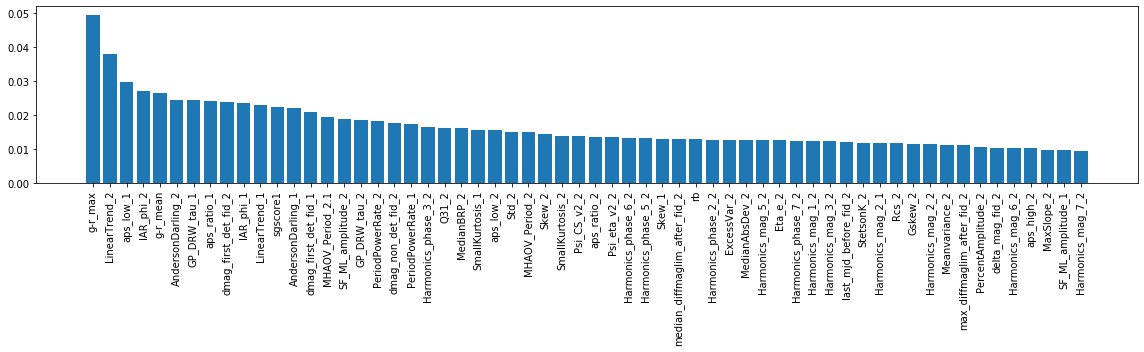

In [25]:
#plotting feature importance
feat_transient2 = plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer,nfeatures)

 ## Putting al layers together  


In [26]:
# generating final probabilities

#multiplying probabilities of the hierarchical layer with the other layers
prob_periodic = y_pred_proba_periodic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic = y_pred_proba_stochastic*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient = y_pred_proba_transient*y_pred_proba_hier[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final = np.concatenate((prob_stochastic,prob_trainsient,prob_periodic),axis=1)

print(np.sum(prob_final,axis=1),np.mean(np.sum(prob_final,axis=1)),np.std(np.sum(prob_final,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba = np.amax(prob_final,axis=1)
class_final_index = np.argmax(prob_final,axis=1)
class_final_name = [prob_final_class_names[x] for x in class_final_index]



[1. 1. 1. ... 1. 1. 1.] 1.0 8.331518834986019e-17
['AGN' 'Blazar' 'CV/Nova' 'LPV' 'QSO' 'YSO' 'SLSN' 'SNII' 'SNIa' 'SNIbc'
 'Ceph' 'DSCT' 'EB' 'Periodic-Other' 'RRL']


[[1868  218   93    2    1    3    2    0    2    1    3    2    0    0
    48]
 [  34  414   17    0    0    1    0    2    3    0    0    2    0    0
     1]
 [  34   22  134    0    1    0    0    0    1    0    1    2    0    0
     2]
 [   0    0    2   82    2    7    4    2    0    2   12   30    4    0
    12]
 [   0    1    0    4  252    0    0    0    0    5    1    6    8    7
    19]
 [   0    1    0    1    0  121   23    8    6    0    0    0    0    0
     0]
 [   0    0    0    0    0    3    6    0    1    0    0    0    0    0
     0]
 [   0    0    0    0    0    7    4   21   12    0    0    0    0    0
     0]
 [   0    0    0    0    0    0    0    0    4    0    0    0    0    0
     0]
 [   1    1    3   33   39    0    1    0    0 4504  523  198  209    3
  1176]
 [   0    0    0    0    0    0    0    0    0   13  112    4    1    0
     3]
 [   0    1    0    4    5    1    2    2    0  195  315 4851   95    2
   501]
 [   0    0    0    0   12    0    0    

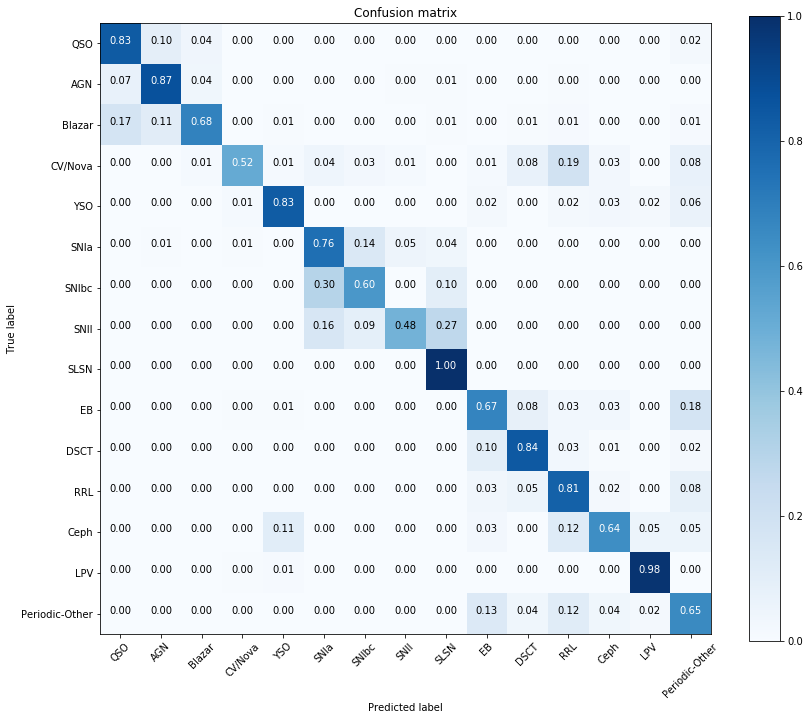

In [27]:
# generating confusion matrix for multilabels
cnf_matrix = metrics.confusion_matrix(y_test_original, class_final_name,labels=label_order)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,label_order, conf_matrix_name_second_layer)


print("Accuracy:", "%0.2f" % metrics.accuracy_score(y_test_original, class_final_name))
print("Balanced accuracy:","%0.2f" %  metrics.balanced_accuracy_score(y_test_original, class_final_name))

print("weighted precision: ","%0.2f" %  metrics.precision_score(y_test_original, class_final_name, average='weighted'))
print("weighted recall: ","%0.2f" %  metrics.recall_score(y_test_original, class_final_name, average='weighted'))
print("weighted F1: ","%0.2f" %  metrics.f1_score(y_test_original, class_final_name, average='weighted'))

In [28]:
# Kaggle score

num_y_test =  [np.where(prob_final_class_names==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

#print(num_y_test)

CLASSES_REDUCED_V2 = prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

AGN -0.04636213407352648
Blazar -0.0634282301496618
CV/Nova -0.11135356449414373
LPV -0.012950023207860964
QSO -0.04244696761606157
YSO -0.05022306186889666
SLSN -0.06610817539305744
SNII -0.08416050784360729
SNIa -0.06877647389510509
SNIbc -0.08982883770189652
Ceph -0.06406581900523672
DSCT -0.04397092987084676
EB -0.06278956030309128
Periodic-Other -0.0841823509521999
RRL -0.05005901402844306
0.9407056504036354


  ## Analysis post classification in training set

In [29]:
oids_test = y_test_original.copy()#.index.values
oids_test = oids_test.to_frame()
classified_names = np.array(class_final_name)

oids_test['pred_class'] = classified_names

print(oids_test.head())

LPV_asAGN = oids_test.loc[(oids_test.class_original=='AGN-I') & (oids_test.pred_class=='QSO-I')].index.values
#LPV_asAGN = y_test_original.loc[y_test_original.values=='QSO-I']


print(LPV_asAGN) 

print(df.loc[LPV_asAGN])
test_csv = df.loc[LPV_asAGN]
test_csv.to_csv('~/Desktop/blazar_class_as_QSO.csv')


             class_original pred_class
oid                                   
ZTF18abgjsra            LPV        LPV
ZTF18abnufyj            RRL        RRL
ZTF19aadunbq            LPV        LPV
ZTF18aaacbyg           Ceph       Ceph
ZTF19aaqsfze            LPV        LPV
[]
Empty DataFrame
Columns: [Amplitude_1, Amplitude_2, AndersonDarling_1, AndersonDarling_2, Autocor_length_1, Autocor_length_2, Beyond1Std_1, Beyond1Std_2, Con_1, Con_2, Eta_e_1, Eta_e_2, ExcessVar_1, ExcessVar_2, GP_DRW_sigma_1, GP_DRW_sigma_2, GP_DRW_tau_1, GP_DRW_tau_2, Gskew_1, Gskew_2, Harmonics_mag_1_1, Harmonics_mag_1_2, Harmonics_mag_2_1, Harmonics_mag_2_2, Harmonics_mag_3_1, Harmonics_mag_3_2, Harmonics_mag_4_1, Harmonics_mag_4_2, Harmonics_mag_5_1, Harmonics_mag_5_2, Harmonics_mag_6_1, Harmonics_mag_6_2, Harmonics_mag_7_1, Harmonics_mag_7_2, Harmonics_mse_1, Harmonics_mse_2, Harmonics_phase_2_1, Harmonics_phase_2_2, Harmonics_phase_3_1, Harmonics_phase_3_2, Harmonics_phase_4_1, Harmonics_phase_4_2, Harmonic

In [30]:

import psycopg2
import json

credentials_file = "alercereaduser.json"
with open(credentials_file) as jsonfile:
    params = json.load(jsonfile)["params"]
    

conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])
    
    
def plotLC(oid, SN_det, SN_nondet):
    fig, ax = plt.subplots(figsize = (10, 5))
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    for fid in [1, 2]:
        mask = SN_det.fid == fid
        if np.sum(mask) > 0:            
            ax.errorbar(SN_det[mask].mjd, SN_det[mask].magpsf_corr, 
                yerr = SN_det[mask].sigmapsf_corr, c = colors[fid], marker = 'o', label = labels[fid])
        #mask = (SN_nondet.fid == fid) & (SN_nondet.diffmaglim > -900)
        #if np.sum(mask) > 0:            
        #    ax.scatter(SN_nondet[mask].mjd, SN_nondet[mask].diffmaglim, c = colors[fid], alpha = 0.5,
        #        marker = 'v', label = "lim.mag. %s" % labels[fid])
    ax.set_title(oid)
    ax.set_xlabel("MJD")
    ax.set_ylabel("Magnitude")
    ax.legend()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    
def getSNdata(oid, doplot = False, doNED = False):

    # query detections and sort by mjd
    query="select oid, ra, dec, fid, mjd, magpsf_corr, sigmapsf_corr from detections where oid='%s'" % oid
    SN_det = pd.read_sql_query(query, conn)
    SN_det.sort_values(by=['mjd'], inplace=True)
        
    # query non detections and sort by mjd
    query="select oid, fid, mjd, diffmaglim from non_detections where oid='%s'" % oid
    SN_nondet = pd.read_sql_query(query, conn)
    SN_nondet.sort_values(by=['mjd'], inplace=True)
    
    if doplot:
        plotLC(oid, SN_det, SN_nondet)
        
    # find NED galaxies
    if doNED:
        co = coordinates.SkyCoord(ra=SNe.meanra[oid], dec=SNe.meandec[oid], unit=(u.deg, u.deg), frame='fk4')
        result_table = Ned.query_region(co, radius=0.01 * u.deg, equinox='J2000.0')
        display(result_table)
                
    # return data
    return SN_det, SN_nondet


for oid in LPV_asAGN:
    getSNdata(oid, doplot = True, doNED = False);

  ## Classifying unlabeled data

In [31]:
#loading the data

rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
             'Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul.fillna(-999,inplace=True)

print(df_feat_ul.n_samples_1.size)

if extragalactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b > 20) | (df_feat_ul.gal_b < -20)]

if galactic:
    df_feat_ul = df_feat_ul[(df_feat_ul.gal_b <= 20) & (df_feat_ul.gal_b >= -20)]
    
if morethan5:
    df_feat_ul = df_feat_ul[(df_feat_ul.n_samples_1 > 5) & (df_feat_ul.n_samples_2 > 5)]
    
df_feat_ul_out = df_feat_ul
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

#df_feat_ul_stochastic.head()
print(df_feat_ul.n_samples_1.size)

KeyError: "['n_det_fid_1' 'n_det_fid_2'] not found in axis"

In [ ]:
#predicting classes of unlabeled data


df_feat_ul_hier = df_feat_ul[feat_hier]
df_feat_ul_periodic = df_feat_ul[feat_periodic]
df_feat_ul_stochastic = df_feat_ul[feat_stochastic]
df_feat_ul_transient = df_feat_ul[feat_transient]


test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul_hier)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul_hier)

test_Y_periodic = rf_model_periodic.predict(df_feat_ul_periodic)
test_Y_proba_periodic = rf_model_periodic.predict_proba(df_feat_ul_periodic)

test_Y_stochastic = rf_model_stochastic.predict(df_feat_ul_stochastic)
test_Y_proba_stochastic = rf_model_stochastic.predict_proba(df_feat_ul_stochastic)

test_Y_transient = rf_model_transient.predict(df_feat_ul_transient)
test_Y_proba_transient = rf_model_transient.predict_proba(df_feat_ul_transient)


#multiplying probabilities
prob_periodic_ul = test_Y_proba_periodic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Periodic')[0][0]].T[:, np.newaxis]
prob_stochastic_ul = test_Y_proba_stochastic*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Stochastic')[0][0]].T[:, np.newaxis]
prob_trainsient_ul = test_Y_proba_transient*test_Y_proba_hierarchical[:,np.where(classes_order_proba_hierarchical=='Transient')[0][0]].T[:, np.newaxis]

#obtaining final probabilities matrix
prob_final_ul = np.concatenate((prob_stochastic_ul,prob_trainsient_ul,prob_periodic_ul),axis=1)

print(np.sum(prob_final_ul,axis=1),np.mean(np.sum(prob_final_ul,axis=1)),np.std(np.sum(prob_final_ul,axis=1)))

#getting the ordered name of classes for prob_final
prob_final_class_names_ul = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))
print(prob_final_class_names)


class_final_proba_ul = np.amax(prob_final_ul,axis=1)
class_final_index_ul = np.argmax(prob_final_ul,axis=1)
class_final_name_ul = [prob_final_class_names_ul[x] for x in class_final_index_ul]


In [ ]:
#Writing results in the output

df_out = df_feat_ul_out
print(df_out.shape)
print(len(class_final_name_ul))
print(len(prob_final_ul))


df_out['predicted_class'] = class_final_name_ul
df_out['predicted_class_proba'] = class_final_proba_ul
test_data_withclass = df_out

'''
probs_header = prob_final_class_names_ul + '_prob'

prob_pd_ul = pd.DataFrame(prob_final_ul,columns=probs_header,index=df_out.index)

prob_h_pd_ul = pd.DataFrame(test_Y_proba_hierarchical, columns=['prob_Periodic','prob_Stochastic','prob_Transient'],index=df_out.index)

test_data_withclass = df_out.join(prob_pd_ul).join(prob_h_pd_ul)

test_data_withclass.to_csv(class_output)

test_data_withclass.head()
'''

In [ ]:
test_data_withclass.shape

In [ ]:
letter_counts = Counter(class_final_name_ul)
df_hist = pd.DataFrame.from_dict(letter_counts, orient='index')
df_hist.plot(kind='bar')
#plt.yscale('log')
plt.title('sources classified')

In [ ]:

fig, ax = plt.subplots(nrows = len(prob_final_class_names_ul), figsize=(12, 20), sharex=True)
for idx, cl in enumerate(prob_final_class_names_ul):
   #print(idx, cl)
   print(idx, cl, np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.))
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   ax[idx].hist(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].values, density=True, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].max(), 1., " %s (%i)" % (cl, test_data_withclass['predicted_class_proba'][test_data_withclass['predicted_class']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

In [ ]:
feature = 'g-r_max'
logscale = False
df_train_plot = df_train.join(labels)
df_train_plot = df_train_plot.loc[df_train_plot[feature]>-999] 
fig, ax = plt.subplots(nrows = len(label_order), figsize=(12, 20), sharex=True)

for idx, cl in enumerate(label_order):
   #print(idx, cl)
   print(idx, cl, np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.))
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 5.), c='g')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 50.), c='r')
   ax[idx].axvline(np.percentile(df_train_plot[feature][df_train_plot['class_original']==cl].values, 95.), c='g')
   ax[idx].axvline(1/len(prob_final_class_names_ul), c = 'k')
   if logscale: ax[idx].hist(np.log10(df_train_plot[feature][df_train_plot['class_original']==cl].values), density=False, bins=40, lw=5, label=cl, alpha=0.8)
   else: ax[idx].hist(df_train_plot[feature][df_train_plot['class_original']==cl].values, density=False, bins=40, lw=5, label=cl, alpha=0.8)
   ax[idx].text(df_train_plot[feature][df_train_plot['class_original']==cl].max(), 1.5, " %s (%i)" % (cl, df_train_plot[feature][df_train_plot['class_original']==cl].shape[0]), fontsize=18, va='bottom', ha='left')

plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'
feature_y = 'gal_b'
#labels_list = ['RS-CVn','Ceph','LPV','RRL','AGN-I','Blazar','SNIa']
labels_list = ['Blazar','QSO-I','AGN-I']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))
#df_train = df_train.join(labels)
df_test = test_data_withclass.loc[(test_data_withclass[feature_y]>-999) & (test_data_withclass[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)

for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_test[feature_x][df_test['predicted_class']==cl].values,df_test[feature_y][df_test['predicted_class']==cl].values,color=colors[idx],alpha = 0.5, s = 3,label=cl)
   
plt.legend()
plt.savefig('../feature_analysis_train_set/color_gal_b_selection.png')

In [ ]:
import matplotlib.cm as cm

feature_x = 'g-r_max'#'GP_DRW_sigma_1'
feature_y = 'gal_b' #'GP_DRW_tau_1'
labels_list = ['LPV','QSO-I','AGN-I','Blazar']
logscale = False
colors = cm.rainbow(np.linspace(0, 1, len(labels_list)))

df_plot = df.join(labels)
df_plot= df_plot.loc[(df_plot[feature_y]>-999) & (df_plot[feature_x]>-999)] 

fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlim(-2,6)
#ax.set_xlim(-4,3)
#ax.set_ylim(-4,5)
for idx, cl in enumerate(labels_list):
   #print(idx, cl)
   ax.scatter(df_plot[feature_x][df_plot['class_original']==cl].values,df_plot[feature_y][df_plot['class_original']==cl].values,color=colors[idx],alpha=0.6,label=cl)
   #ax.scatter(np.log10(df_plot[feature_x][df_plot['class_original']==cl].values),np.log10(df_plot[feature_y][df_plot['class_original']==cl].values),color=colors[idx],alpha=0.6,label=cl)
   
plt.legend()
#plt.savefig('../feature_analysis_train_set/'+feature+'.pdf')